In [1]:
import os, sys, time
import numpy as np
import h5py
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import wandb
sys.path.insert(1, './FourCastNet/') # insert code repo into path

# you may need to
# !pip install ruamel.yaml einops timm
# (or conda install)

from utils.YParams import YParams
from networks.afnonet import AFNONet

from constants import VARIABLES
from proj_utils import load_model, inference, lat, latitude_weighting_factor, weighted_rmse_channels
from distributed_utils import inference_ensemble

PLOT_INPUTS = False # to get a sample plot

/global/homes/j/jhalpern/.conda/envs/hpml_env/lib/python3.13/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
# DO THIS WITHIN YOUR SCRATCH AND SET PATH
# wget https://portal.nersc.gov/project/m4134/ccai_demo.tar
# tar -xvf ccai_demo.tar
# rm ccai_demo.tar

base_path = "/pscratch/sd/j/jhalpern/hpml/" # update to yours

# data and model paths
data_path = f"{base_path}ccai_demo/data/FCN_ERA5_data_v0/out_of_sample"
data_file = os.path.join(data_path, "2018.h5")
model_path = f"{base_path}ccai_demo/model_weights/FCN_weights_v0/backbone.ckpt"
global_means_path = f"{base_path}ccai_demo/additional/stats_v0/global_means.npy"
global_stds_path = f"{base_path}ccai_demo/additional/stats_v0/global_stds.npy"
time_means_path = f"{base_path}ccai_demo/additional/stats_v0/time_means.npy"
land_sea_mask_path = f"{base_path}ccai_demo/additional/stats_v0/land_sea_mask.npy"

In [3]:
os.environ["WANDB_NOTEBOOK_NAME"] = './base_notebook.ipynb' # this will be the name of the notebook in the wandb project database
wandb.login()
run = wandb.init(
    project="weather-forecast-inference",    # Specify your project
    config={                         # Track hyperparameters and metadata
    },
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jhalpern (jhalpern-columbia-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [4]:
# default
config_file = "./FourCastNet/config/AFNO.yaml"
config_name = "afno_backbone"
params = YParams(config_file, config_name)
print("Model architecture used = {}".format(params["nettype"]))

Model architecture used = afno


Total data shape: (40, 21, 721, 1440)


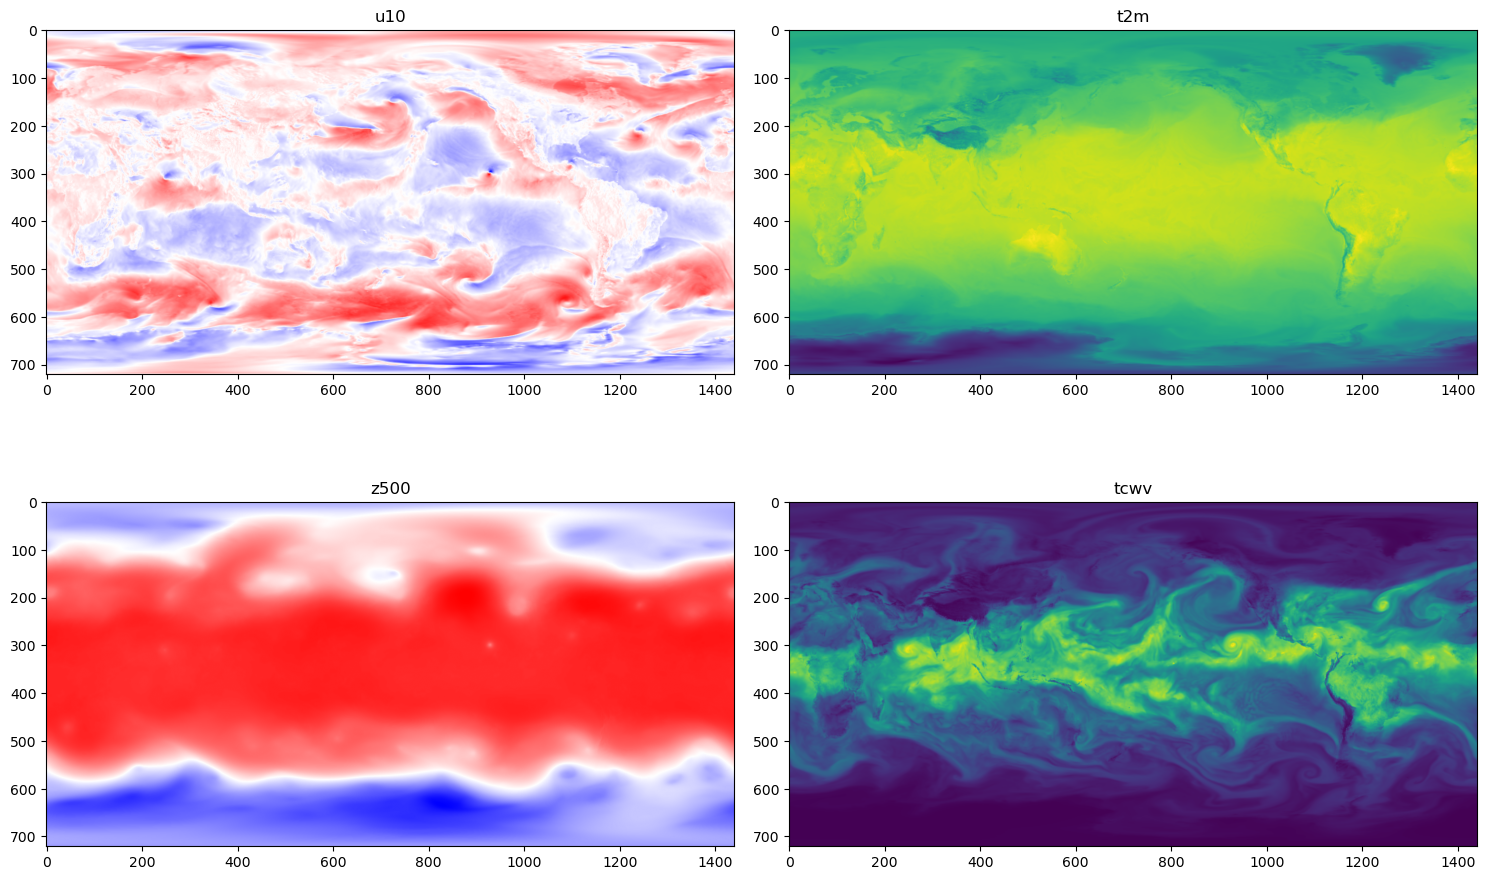

In [5]:
if PLOT_INPUTS:
    sample_data = h5py.File(data_file, 'r')['fields']
    print('Total data shape:', sample_data.shape)
    timestep_idx = 0
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    for i, varname in enumerate(['u10', 't2m', 'z500', 'tcwv']):
        cm = 'bwr' if varname == 'u10' or varname == 'z500' else 'viridis'
        varidx = VARIABLES.index(varname)
        ax[i//2][i%2].imshow(sample_data[timestep_idx, varidx], cmap=cm)
        ax[i//2][i%2].set_title(varname)
    fig.tight_layout()

In [6]:
# import model
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'

# in and out channels: FourCastNet uses 20 input channels corresponding to 20 prognostic variables
in_channels = np.array(params.in_channels)
out_channels = np.array(params.out_channels)
params['N_in_channels'] = len(in_channels)
params['N_out_channels'] = len(out_channels)
params.means = np.load(global_means_path)[0, out_channels] # for normalizing data with precomputed train stats
params.stds = np.load(global_stds_path)[0, out_channels]
params.time_means = np.load(time_means_path)[0, out_channels]

# load the model
if params.nettype == 'afno':
    model = AFNONet(params).to(device)  # AFNO model
else:
    raise Exception("not implemented")
# load saved model weights
model = load_model(model, params, model_path)
model = model.to(device)

In [7]:
# move normalization tensors to gpu
# load time means: represents climatology
img_shape_x = 720
img_shape_y = 1440

# means and stds over training data
means = params.means
stds = params.stds

# load climatological means
time_means = params.time_means # temporal mean (for every pixel)
m = torch.as_tensor((time_means - means)/stds)[:, 0:img_shape_x]
m = torch.unsqueeze(m, 0)
# these are needed to compute ACC and RMSE metrics
m = m.to(device, dtype=torch.float)
std = torch.as_tensor(stds[:,0,0]).to(device, dtype=torch.float)

print("Shape of time means = {}".format(m.shape))
print("Shape of std = {}".format(std.shape))

Shape of time means = torch.Size([1, 20, 720, 1440])
Shape of std = torch.Size([20])


In [8]:
# setup data for inference
dt = 1 # time step (x 6 hours)
ic = 0 # start the inference from here
prediction_length = 20 # number of steps (x 6 hours)

# which field to track for visualization
field = 'u10'
idx_vis = VARIABLES.index(field) # also prints out metrics for this field

# get prediction length slice from the data
print('Loading inference data')
print('Inference data from {}'.format(data_file))
data = h5py.File(data_file, 'r')['fields'][ic:(ic+prediction_length*dt):dt,in_channels,0:img_shape_x]
print(data.shape)
print("Shape of data = {}".format(data.shape))

Loading inference data
Inference data from /pscratch/sd/j/jhalpern/hpml/ccai_demo/data/FCN_ERA5_data_v0/out_of_sample/2018.h5
(20, 20, 720, 1440)
Shape of data = (20, 20, 720, 1440)


In [9]:
# run inference
data = (data - means)/stds # standardize the data
data = torch.as_tensor(data).to(device, dtype=torch.float) # move to gpu for inference
acc_cpu, rmse_cpu, predictions_cpu, targets_cpu = inference(data, model, prediction_length, idx=idx_vis,
                                                            params = params, device = device, 
                                                            img_shape_x = img_shape_x, img_shape_y = img_shape_y, std = std, m =m, field = field)

Predicted timestep 0 of 20. u10 RMS Error: 0.0, ACC: 1.0
Predicted timestep 1 of 20. u10 RMS Error: 0.5596160888671875, ACC: 0.9900780916213989
Predicted timestep 2 of 20. u10 RMS Error: 0.7683386206626892, ACC: 0.9802827835083008
Predicted timestep 3 of 20. u10 RMS Error: 0.8545043468475342, ACC: 0.9751383066177368
Predicted timestep 4 of 20. u10 RMS Error: 0.9779791831970215, ACC: 0.966327965259552
Predicted timestep 5 of 20. u10 RMS Error: 1.0723881721496582, ACC: 0.9600257873535156
Predicted timestep 6 of 20. u10 RMS Error: 1.2339807748794556, ACC: 0.946362316608429
Predicted timestep 7 of 20. u10 RMS Error: 1.3772971630096436, ACC: 0.9345548152923584
Predicted timestep 8 of 20. u10 RMS Error: 1.5802643299102783, ACC: 0.9138451814651489
Predicted timestep 9 of 20. u10 RMS Error: 1.7349448204040527, ACC: 0.9004244208335876
Predicted timestep 10 of 20. u10 RMS Error: 1.9254651069641113, ACC: 0.8790378570556641
Predicted timestep 11 of 20. u10 RMS Error: 2.1220521926879883, ACC: 0.857

In [10]:
ensemble_size = 2
base_initial = data[0:1]  # shape: [1, channels, img_shape_x, img_shape_y]

# replicate to create an ensemble and add a small perturbation (e.g., 1e-3 scaling factor)
ensemble_init = base_initial.repeat(ensemble_size, 1, 1, 1)
epsilon = 1e-3  # perturbation magnitude
ensemble_init += epsilon * torch.randn_like(ensemble_init)

# Set the prediction length (number of autoregressive steps)
prediction_length = 20  # as before

# Run the ensemble inference and measure the performance
ensemble_predictions, inference_time = inference_ensemble(ensemble_init, model, prediction_length, device = device)

Total inference time for 2 ensemble members over 20 steps: 5.537 seconds
